In [1]:
from os import stat
import matplotlib.pyplot as plt
import numpy as np
import json
import toml
import matplotlib.animation as anim
from IPython.display import HTML

def load_sim_states(fname):
    """Load states during simulation."""
    with open(fname, "r") as f:
        states = []
        for line in f:
            states.append(json.loads(line))
        return states
        
def load_toml(fname = "../zebra.toml"):
    """Load config toml."""
    with open(fname, "r") as f:
        parsed_toml = toml.loads(f.read())
    return parsed_toml

# Load zebra toml
zebra_toml = load_toml()

# Load states
states = load_sim_states("../sim_states.json")

# Testing
# state = states[100]
# ped_xs = [zebra_toml["zebra_crossings"][int(ped["location"])] for ped in state["pedestrians"]]
# veh_xs = [float(vehicle["position"]) for vehicle in state["vehicles"]]

In [2]:
# Function to create animation
def get_animation(states):
    fig = plt.figure(figsize=(10, 4))  
    ax1 = fig.add_subplot(1,1,1)
    FRAME_LIMIT = 2000
    GAP = 0.1
    WIDTH = 0.4
    LENGTH = 10
    N_STRIPES = 7
    ROAD_WIDTH = 0.15
    MAX_LENGTH = zebra_toml["road_length"] + 1

    ax1.set_xlim(0, MAX_LENGTH)
    min_y, max_y = -1, 1
    ax1.set_ylim(min_y, max_y)
    # ax1.axis("off")
    ax1.spines.right.set_visible(False)
    ax1.spines.top.set_visible(False)
    ax1.spines.left.set_visible(False)
    ax1.tick_params(left=False)
    ax1.tick_params(labelleft=False)
    
    # vlines = ax1.vlines(np.arange(0, MAX_LENGTH, 100), min_y, max_y, ls=":", color="grey", lw=.5, zorder=-1)
    # hlines = []
    # for crossing in zebra_toml["zebra_crossings"]:
    #     hlines.append(
    #         ax1.hlines(np.linspace(-WIDTH, WIDTH, N_STRIPES), crossing, crossing+LENGTH, color="k", lw=5, zorder=-4)
    #     )
    ped_scat, = ax1.plot([], [], color="dodgerblue", marker="o", markersize=9, ls="None")
    veh_scat_up, = ax1.plot([], [], marker=">", color="firebrick", ms=5, ls="None")
    veh_scat_down, = ax1.plot([], [], marker="<", color="purple", ms=5, ls="None")

    time_text = ax1.text(0, 1, "", ha="left", va="bottom", transform = ax1.transAxes, fontsize="large")
    
    def convert_millis(ms):
        secs = int((ms / 1000)) % 60
        mins = int(ms / (1000 * 60)) % 60
        hrs = int(ms / (1000 * 60 * 60)) % 24
        return hrs, mins, secs
    
    def init():
        vlines = ax1.vlines(np.arange(0, MAX_LENGTH, 100), min_y, max_y, ls=":", color="grey", lw=.5, zorder=-1)
        hlines = []
        for crossing in zebra_toml["zebra_crossings"]:
            hlines.append(
                ax1.hlines(np.linspace(-WIDTH, WIDTH, N_STRIPES), crossing-LENGTH/2, crossing+LENGTH/2, color="k", lw=5, zorder=-4)
            )

        ped_scat, = ax1.plot([], [], color="dodgerblue", marker="o", markersize=9, ls="None")
        veh_scat_up, = ax1.plot([], [], marker=">", color="firebrick", ms=5, ls="None")
        veh_scat_down, = ax1.plot([], [], marker="<", color="purple", ms=5, ls="None")
        time_text = ax1.text(0, 1, "", ha="left", va="bottom", transform = ax1.transAxes, fontsize="large")
        return ped_scat, veh_scat_up, veh_scat_down, time_text
    
    def animate(i):
        from matplotlib.artist import Artist
        state = states[i]
        timestamp = int(state["timestamp"])
        hrs, mins, secs = convert_millis(timestamp)
        ped_xs = [zebra_toml["zebra_crossings"][int(ped["location"])] for ped in state["pedestrians"]]
        ped_ys = []
        counts = {}
        for el in ped_xs:
            if el in counts:
                counts[el] += GAP
            else:
                counts[el] = GAP + WIDTH
            ped_ys.append(counts[el])

        veh_xs_up = [float(vehicle["position"]) for vehicle in state["vehicles"] if vehicle["direction"] == "Up"]
        veh_ys_up = len(veh_xs_up)*[ROAD_WIDTH/2]
        veh_xs_down = [zebra_toml["road_length"]-float(vehicle["position"]) for vehicle in state["vehicles"] if vehicle["direction"] == "Down"]
        veh_ys_down = len(veh_xs_down)*[-ROAD_WIDTH/2]
        
        # Update plots
        ped_scat.set_data(ped_xs, ped_ys)
        veh_scat_up.set_data(veh_xs_up, veh_ys_up)
        veh_scat_down.set_data(veh_xs_down, veh_ys_down)
        time_text.set_text(f"Time: {hrs:02.0f}h{mins:02.0f}m{secs:02.0f}s")        
        return (ped_scat, veh_scat_up, veh_scat_down, time_text)

    return anim.FuncAnimation(
        fig, animate,
        init_func=init,
        frames=np.arange(0, min(FRAME_LIMIT, len(states))),
        repeat=False,
        blit=True,
        interval=100
    )

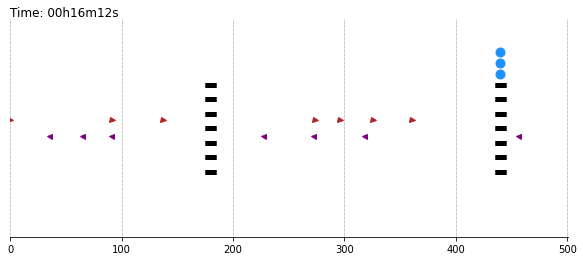

In [3]:
# Make animation and save as gif
animation = get_animation(states)
html5 = animation.to_html5_video()
HTML(html5)

In [4]:
# Save as mp4 and gif
fname = "zebra_animation.mp4"
animation.save(fname, dpi=100, fps=20, writer="ffmpeg")
!convert zebra_animation.mp4 zebra_animation.gif